In [10]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


In [43]:

def dataset(Path,Name):

    pathFile = '\\'.join([Path,Name])

    dict_cols = ['trafficSource','totals','geoNetwork','device'] 

    df = pd.read_csv(pathFile, dtype={'fullVisitorId': 'str'}, nrows=None)

    for column in dict_cols:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    try:
        df['Revenue']=df['transactionRevenue']
    except:    
        df['Revenue']=0

    cols = df.columns.tolist()
    
    source_stats = df[['source','fullVisitorId']].groupby('source').count().reset_index()
    source_sorted = source_stats.sort_values(by='fullVisitorId',ascending=False).iloc[:20,:]
    
    plt.figure(figsize=(14,10))
    sns.barplot(x="fullVisitorId", y="source", data=source_sorted)
    plt.title('Source distribution')
    plt.tight_layout()
    plt.show()
    
    source_sorted_top = source_sorted['source'].tolist()
    
    def categorie(value):
        cat = 'Other'

        for val in source_sorted_top:
            if val.strip() == value.strip():
                return val

        return cat
    
    def is_google_source(value):
        if value.lower().find('google') >= 0:
            return True
        else:
            return False
    
    df['source_cat'] = df['source'].apply(categorie)
    df['source_google'] = df['source'].apply(is_google_source)
        
    print('--'*30)
    print(df.shape)

    liste_features = ['Revenue',
                        'fullVisitorId', 
                        'bounces', 
                        'hits', 
                        'newVisits', 
                        'pageviews', 
                        'visits', 
                        'subContinent', 
                        'deviceCategory', 
                        'isMobile',
                        'source_google']

    new_df = df[liste_features]    
    
    col_dummies = [     'source_google',                
                        'subContinent', 
                        'deviceCategory', 
                        'isMobile']

    for col in col_dummies:
        dummies = pd.get_dummies(new_df[col],prefix=col)
        new_df = pd.concat([new_df,dummies],axis=1)
        #new_df.drop(col)


    new_df = new_df.drop(col_dummies,axis=1)

    return new_df


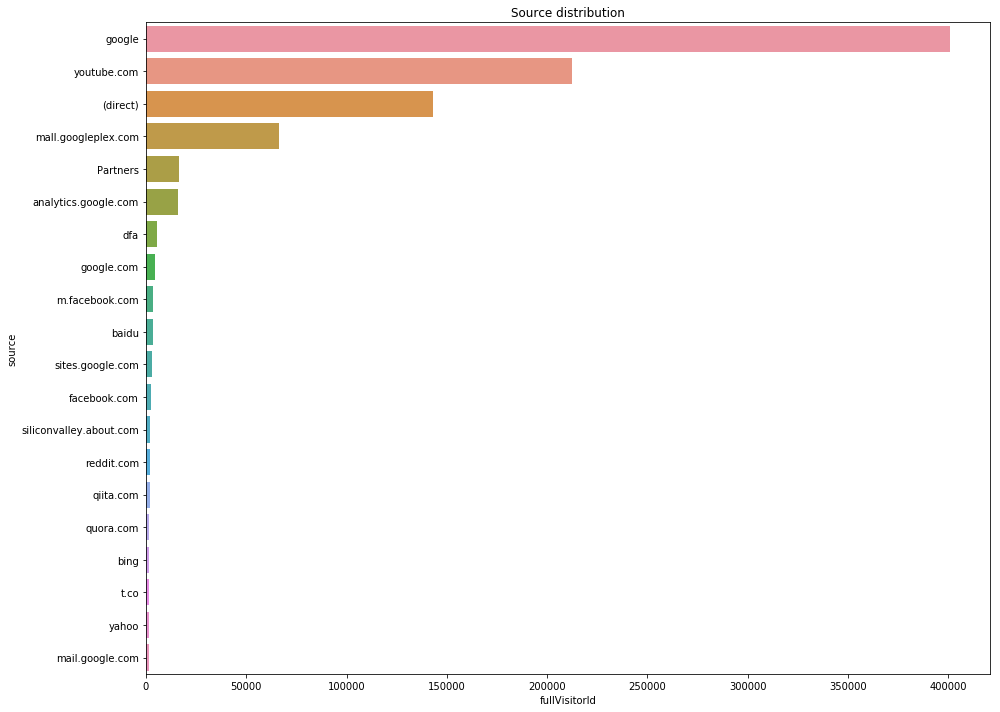

------------------------------------------------------------
(903653, 53)


In [44]:
Path = 'c:\\users\\monne\\Desktop\\Google Analytics Customers'
Name = 'train.csv'

train_features = dataset(Path,Name)

In [45]:
train_features = train_features.fillna(0)
print(train_features.shape)

(903653, 37)


In [46]:
train_target = train_features.pop('Revenue')
train_id = train_features.pop('fullVisitorId')
print(train_target.shape)
print(train_id.shape)

(903653,)
(903653,)


In [47]:
train_targets = train_target.copy()
print(type(train_targets))

<class 'pandas.core.series.Series'>


In [48]:
train_targets = train_targets.fillna(0)
print(train_targets.isna().sum())
train_targets = train_targets.astype(np.float)
train_targets = train_targets + 1
print(train_targets.unique())
print(train_targets.max())
print(train_targets.min())

0
[  1.00000000e+00   3.78600010e+07   3.06670001e+08 ...,   3.35260001e+08
   3.07500010e+07   6.93900010e+07]
23129500001.0
1.0


In [49]:
train_targets = np.log(train_targets)
print(train_targets.unique())

[  0.          17.44940573  19.54128281 ...,  19.63041691  17.24140058
  18.05525334]


In [50]:
train_target_shape = train_targets.values.reshape(-1,1)
print(train_target_shape)

[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


In [51]:
train_targets.describe()

count    903653.000000
mean          0.227118
std           2.003710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.864375
Name: Revenue, dtype: float64

In [52]:
X = train_features.as_matrix().astype(np.float)
y = train_targets.as_matrix().astype(np.float)

In [53]:
#from sklearn.tree import DecisionTreeRegressor 
#lr = LinearRegression()
from sklearn.ensemble import RandomForestRegressor
lr = RandomForestRegressor(n_estimators=10,
                           random_state=1)

lr.fit(train_features,train_targets)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

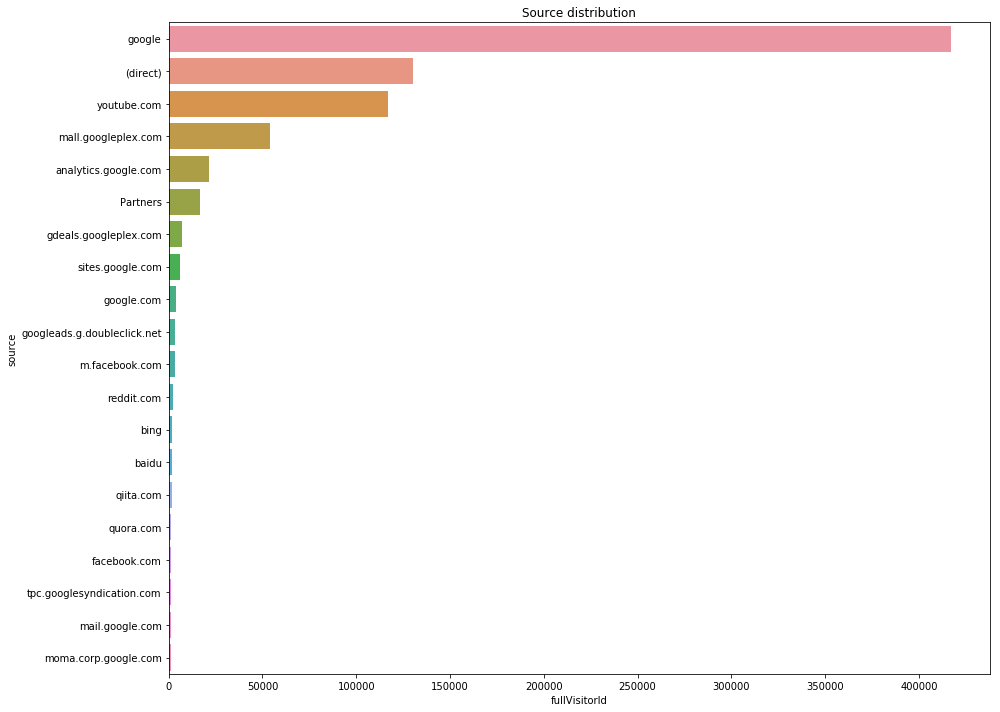

------------------------------------------------------------
(804684, 51)


In [54]:
Name = 'test.csv'

test_features = dataset(Path,Name)

In [55]:
test_features = test_features.fillna(0)
print(test_features.shape)

(804684, 37)


In [56]:
test_target = test_features.pop('Revenue')
test_id = test_features.pop('fullVisitorId')
print(test_target.shape)
print(test_id.shape)

(804684,)
(804684,)


In [57]:
test_targets = test_target.copy()
print(type(test_targets))

<class 'pandas.core.series.Series'>


In [58]:
test_targets = test_targets.fillna(0)
print(test_targets.isna().sum())
test_targets = test_targets.astype(np.float)
test_targets = test_targets + 1
print(test_targets.unique())
print(test_targets.max())
print(test_targets.min())

0
[ 1.]
1.0
1.0


In [59]:
test_targets = np.log(test_targets)
print(test_targets.unique())

[ 0.]


In [60]:
print(test_features.shape)
print(train_features.shape)
for col in train_features.columns.tolist():
    print(col)


(804684, 35)
(903653, 35)
bounces
hits
newVisits
pageviews
visits
source_google_False
source_google_True
subContinent_(not set)
subContinent_Australasia
subContinent_Caribbean
subContinent_Central America
subContinent_Central Asia
subContinent_Eastern Africa
subContinent_Eastern Asia
subContinent_Eastern Europe
subContinent_Melanesia
subContinent_Micronesian Region
subContinent_Middle Africa
subContinent_Northern Africa
subContinent_Northern America
subContinent_Northern Europe
subContinent_Polynesia
subContinent_South America
subContinent_Southeast Asia
subContinent_Southern Africa
subContinent_Southern Asia
subContinent_Southern Europe
subContinent_Western Africa
subContinent_Western Asia
subContinent_Western Europe
deviceCategory_desktop
deviceCategory_mobile
deviceCategory_tablet
isMobile_False
isMobile_True


In [61]:
for col in test_features.columns.tolist():
    print(col)

bounces
hits
newVisits
pageviews
visits
source_google_False
source_google_True
subContinent_(not set)
subContinent_Australasia
subContinent_Caribbean
subContinent_Central America
subContinent_Central Asia
subContinent_Eastern Africa
subContinent_Eastern Asia
subContinent_Eastern Europe
subContinent_Melanesia
subContinent_Micronesian Region
subContinent_Middle Africa
subContinent_Northern Africa
subContinent_Northern America
subContinent_Northern Europe
subContinent_Polynesia
subContinent_South America
subContinent_Southeast Asia
subContinent_Southern Africa
subContinent_Southern Asia
subContinent_Southern Europe
subContinent_Western Africa
subContinent_Western Asia
subContinent_Western Europe
deviceCategory_desktop
deviceCategory_mobile
deviceCategory_tablet
isMobile_False
isMobile_True


In [62]:
predictions_revenue = lr.predict(test_features)

In [63]:
mse = np.array((test_targets - predictions_revenue)**2).sum()
rmse = np.sqrt(mse)

print('--'*20)
print(f"Mean square error : {mse}")
print(f"Root mean square error : {rmse}")
print('--'*20)


----------------------------------------
Mean square error : 753162.823752735
Root mean square error : 867.849539812481
----------------------------------------


In [64]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
predictions_revenue[predictions_revenue < 0] = 0

In [65]:
sub_df["PredictedLogRevenue"] = np.expm1(predictions_revenue)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [66]:
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])

print('--'*20)
print(sub_df.head())
print('--'*20)


----------------------------------------
         fullVisitorId  PredictedLogRevenue
0  0000000259678714014              0.00000
1  0000049363351866189              0.00000
2  0000053049821714864              0.00000
3  0000059488412965267              0.00000
4  0000085840370633780              0.00146
----------------------------------------


In [67]:
Path = 'c:\\users\\monne\\Desktop'
Name = 'Submission 2018-10-03.csv'
pathFile = '\\'.join([Path,Name])
sub_df.to_csv(pathFile, index=False)
